# Address Matching with Libpostal and Deep Learning

This notebook matches addresses by parsing them with Libpostal and using that structure in a transformers deep learning model.

In [1]:
import json
import logging
import os
import random
import re
import sys
import time
import warnings
from numbers import Number
from typing import Callable, Dict, List, Literal, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pytest
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from datasets import Dataset
from fuzzywuzzy import fuzz

from postal.parser import parse_address
from scipy.spatial import distance
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample, SentenceTransformer, SentencesDataset, SentenceTransformerTrainer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction, BinaryClassificationEvaluator
from sentence_transformers.model_card import SentenceTransformerModelCardData
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from tenacity import retry
from torch.utils.data import DataLoader
from torch.optim import RAdam
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.integrations import WandbCallback

from utils import (
    augment_gold_labels,
    compute_sbert_metrics,
    compute_classifier_metrics,
    format_dataset,
    gold_label_report,
    preprocess_logits_for_metrics,
    structured_encode_address,
    tokenize_function,
    to_dict,
    save_transformer,
    load_transformer,
)

#### Pin Random Seeds for Reproducibility

In [2]:
RANDOM_SEED = 31337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

#### Setup Basic Logging

In [3]:
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

logger = logging.getLogger(__name__)

#### Ignore Warnings

In [4]:
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

#### Configure Weights & Biases

`wandb` needs some environment variables to work.

In [5]:
os.environ["WANDB_LOG_MODEL"] = "end"
os.environ["WANDB_WATCH"] = "gradients"
os.environ["WANDB_PROJECT"] = "libpostal-reborn"
os.environ["WANDB_DISABLED"] = "false"
os.environ["WANDB_IGNORE_GLOBS"] = ".env"

#### Optionally Disable `wandb` Uploads

Weights and Biases can be slow...

In [6]:
os.environ["WANDB_MODE"] = "online"

#### Configure Huggingface APIs

In [7]:
os.environ["HF_ENDPOINT"] = "https://huggingface.co/"

#### Configure Huggingface APIs

Squash any warnings...

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Configure Pandas to Show More Rows

In [9]:
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", None)

### Use CUDA or MPS if Avaialable

CPU training and even inference with sentence transformers and deep learning models is quite slow. Since all machine learning in this library is based on [PyTorch](https://pytorch.org/get-started/locally/), we can assign all ML operations to a GPU in this one block of code. Otherwise we default to CPU without acceleration. The notebook is still workable in this mode, you just may need to grab a cup of tea or coffee while you wait for it to train the Sentence-BERT model below.

In [10]:
# Check for CUDA or MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.debug("Using Apple GPU acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    logger.debug("Using NVIDIA CUDA GPU acceleration")
else:
    device = "cpu"
    logger.debug("Using CPU for ML")

device

device(type='cuda')

### Use Weights & Biases for Logging Metrics

Weights & Biases has a free account for individuals with public projects. Using it will produce charts during our training runs that anyone can view. You can create your own project for this notebook and login with that key to log your own training runs.

You may need to run the following command from your shell before the next cell, otherwise you will have to paste your project key into the 

```bash
wandb login
```

In [11]:
# Login to wandb. Comment out if you already haven't via `wandb login` from a CLI
wandb.login()

wandb: Currently logged in as: rjurney. Use `wandb login --relogin` to force relogin


True

## Data Augmentation with the OpenAI GPT4o API

We need training data for our supervised learning approaches to addres matching. Open the sister notebook [Address Data Augmentation.ipynb](Address%20Matching%20Deep%20Dive.ipynb) before procceeding to further cells in order to create some training data via minimal manual labeling and programmatic data labeling for data augmentation. This will teach you programmatic data labeling, a critical skill that LLMs make MUCH EASIER because they understand things like the semantics of global addresses.

In [12]:
gold_df = pd.read_csv("data/gold.csv")

In [13]:
# If you want to start from here and not run the data augmentation pipeline again...
augment_results_df = pd.read_parquet("data/training.6.parquet")

augment_results_df.head(20)

,Address1,Address2,Description,Label
0,"123 E Main St, Springfield, IL 62701","123 East Main Street, Springfield, Illinois 62701",Different directional prefix formats for same ...,1.0
1,"456 W Elm St, Boston, MA 02118","456 West Elm Street, Boston, Massachusetts 02118",Different directional prefix formats for same ...,1.0
2,"789 S Oak St, Denver, CO 80203","789 South Oak Street, Denver, Colorado 80203",Different directional prefix formats for same ...,1.0
3,"321 N Pine St, Seattle, WA 98101","321 North Pine Street, Seattle, Washington 98101",Different directional prefix formats for same ...,1.0
4,"654 E Maple St, Austin, TX 73301","654 East Maple Street, Austin, Texas 73301",Different directional prefix formats for same ...,1.0
5,"987 W Cedar St, San Francisco, CA 94102","987 West Cedar Street, San Francisco, Californ...",Different directional prefix formats for same ...,1.0
6,"246 S Birch St, New York, NY 10001","246 South Birch Street, New York, New York 10001",Different directional prefix formats for same ...,1.0
7,"135 N Cedar Ave, Chicago, IL 60601","135 North Cedar Avenue, Chicago, Illinois 60601",Different directional prefix formats for same ...,1.0
8,"864 E Pine Ave, Los Angeles, CA 90001","864 East Pine Avenue, Los Angeles, California ...",Different directional prefix formats for same ...,1.0
9,"753 W Spruce St, Houston, TX 77001","753 West Spruce Street, Houston, Texas 77001",Different directional prefix formats for same ...,1.0


### Data Augmentation Complete!

Starting by hand labeling under 100 records and iterating a few times on data augmentation instructions for GPT4o, we have multiplied them by many times to get almost 10,000 synthetic records! This is enough to fine-tune a `SentenceTransformer` or semantic text similarity classifier model. GPT4o is a powerful tool for data augmentation! This can work for a variety of problems.

LLM based data augmentation is a powerful tool for your data labeling toolbox.

# Comparing Different Approaches to Address Matching

Now we're going to compare the following methods of address matching:

1) Database Lookups - we'l use [pycountry](https://pypi.org/project/pycountry/) ([github](https://github.com/pycountry/pycountry)) to improve international address matching (see [PyCountry Nation Matching](PyCountry%20Nation%20Matching.ipynb)).
2) Text Embeddings - we'll use transfer learning to load an existing [SentenceTransformer](https://sbert.net) model to sentence encode pairs of addresses to create fixed-length embeddings for each address and then compute a similarity score via [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). This won't work without fine-tuning, so we fine-tune the model to the task.
3) Deep Matching Model - We'll train a deep semantic textual similarity classification model based on a Siamese BERT network as defined in [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify address pairs as matching or not matching.

# Machine Learning Approaches to Address Matching

In this section we pursue two machine learning approaches to address matching, in order of sophistication. First we fine-tune a pre-trained embedding model to our task, try it on our data and search for a threshold similarity that results in good performance for our address matching problem. Second we build a Siamese BERT network model based on [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify pairs of addresses as match or mismatch. We will train it using the same dataset we use to fine-tune a sentence transformer, and if we have enough training data this will likely be a more powerful approach.

# Parsed Address Matching with Libpostal, PyTorch and `Cosine-Sentence-BERT`

Our next strategy will be to parse the addresses using Libpostal and then to encode them in a way that perserves the parsed staructure. We will use a deep network architecture called `Cosine-Sentence-BERT`, a derivative of `Sentence-BERT`, to build a classifier for pairs of addresses that can achieve better performance than fine-tuned sentence transformers and cosine similarity alone.

Embeddings as a solution to this problem have a side-effect of optimizing an embedding for information retrieval... but they ignore the structure of parsed addresses. A deep network that is aware of it can perform better. Let's try out an implementation of the Sentence-BERT model, which was outlined by Nils Reimers and Iryna Gurevych in the original paper that created sentence tranformers, [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks
](https://arxiv.org/abs/1908.10084).

In [14]:
from typing import List, Tuple
from collections import defaultdict

def parse_standardize_address(address: str) -> str:
    """Parse with Libpostal, then stringify fields in standard order"""

    # Libpostal parse the address
    parsed_address: List[Tuple[str, str]] = parse_address(address)
    
    FIELD_ORDER = [
        "house_number",
        "house",
        "road",
        "unit",
        "level",
        "staircase",
        "entrance",
        "category",
        "near",
        "suburb",
        "city_district",
        "city",
        "island",
        "state_district",
        "state",
        "postcode",
        "po_box",
        "country_region",
        "country",
        "world_region"
    ]
    
    # Fields that typically precede a comma in addresses
    COMMA_AFTER = {"road", "city", "state", "country_region"}
    
    # Create a defaultdict to group values by field
    address_dict = defaultdict(list)
    for value, field in parsed_address:
        if value.strip():
            address_dict[field].append(value.strip())
    
    # Create a list of non-empty address components in the specified order
    address_components = []
    for field in FIELD_ORDER:
        if field in address_dict:
            component = ' '.join(address_dict[field])
            if field in COMMA_AFTER and field != FIELD_ORDER[-1]:
                component += ','
            address_components.append(component)
    
    # Manually join the components with a space unless they are null
    address_string = str()
    for address_component in address_components:
        if address_component and isinstance(address_component, str) and len(address_component) > 0 and address_component != ",":
            address_string += address_component + " "
    
    return address_string.strip()

In [15]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

# Encode the addresses using [COL] / [VAL] special characters
parsed_train_dataset = Dataset.from_dict({
    "sentence1": [parse_standardize_address(x) for x in train_df["Address1"].tolist()],
    "sentence2": [parse_standardize_address(x) for x in train_df["Address2"].tolist()],
    "label": train_df["Label"].tolist(),
})
train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

# Encode the addresses using [COL] / [VAL] special characters
parsed_eval_dataset = Dataset.from_dict({
    "sentence1": [parse_standardize_address(x) for x in eval_df["Address1"].tolist()],
    "sentence2": [parse_standardize_address(x) for x in eval_df["Address2"].tolist()],
    "label": eval_df["Label"].tolist(),
})
eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

# Encode the addresses using [COL] / [VAL] special characters
parsed_test_dataset = Dataset.from_dict({
    "sentence1": [parse_standardize_address(x) for x in test_df["Address1"].tolist()],
    "sentence2": [parse_standardize_address(x) for x in test_df["Address2"].tolist()],
    "label": test_df["Label"].tolist(),
})
test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


In [16]:
SBERT_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "raw-embeddings"
MODEL_SAVE_NAME = ("Cosine-Sentence-BERT" + "-" + VARIANT).replace("/", "-")

EPOCHS = 12
BATCH_SIZE = 16
PATIENCE = 2
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.02
MODEL_OUTPUT_FOLDER = f"data/{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

LIBPOSTAL = True

### Substitute Libpostal Parsed `Datasets`

In [17]:
if LIBPOSTAL:
    logging.error("Using LIBPOSTAL dataset")
    train_dataset = parsed_train_dataset
    eval_dataset = parsed_eval_dataset
    test_dataset = parsed_test_dataset
else:
    logging.error("Using raw dataset")

ERROR:root:Using LIBPOSTAL dataset


In [18]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "model": "Cosine-Sentence-BERT",
        "variant": VARIANT,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL,
        "model_output_folder": MODEL_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
        "model_save_name": MODEL_SAVE_NAME,
        "weight_decay": WEIGHT_DECAY,
        "libpostal": LIBPOSTAL,
    },
    save_code=True,
)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer


class CosineSentenceBERT(nn.Module):
    def __init__(self, model_name=SBERT_MODEL, dim=384):
        super().__init__()
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Update the FFNN to output embedding dimension
        self.ffnn = nn.Sequential(
            nn.Linear(dim, dim//2),
            nn.GELU(),
            nn.Dropout(0.1),
        )

    @staticmethod
    def mean_pool(token_embeds, attention_mask):
        in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
        pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
        return pool

    def encode(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)[0]
        embeddings = self.mean_pool(outputs, attention_mask)
        return self.ffnn(embeddings)

    def forward(self, input_ids_a, input_ids_b, attention_mask_a=None, attention_mask_b=None, labels=None, **kwargs):
        # Encode both sentences
        embed_a = self.encode(input_ids_a, attention_mask_a)
        embed_b = self.encode(input_ids_b, attention_mask_b)

        # Compute cosine similarity
        cosine_sim = F.cosine_similarity(embed_a, embed_b)

        loss = None
        if labels is not None:
            loss_fct = nn.CosineEmbeddingLoss()
            # CosineEmbeddingLoss expects 1 for similar pairs and -1 for dissimilar pairs
            loss = loss_fct(embed_a, embed_b, (labels * 2) - 1)

        return {"loss": loss, "similarity": cosine_sim}

    def predict(self, a: str, b: str):
        encoded_a = self.tokenizer(a, padding=True, truncation=True, return_tensors="pt")
        encoded_b = self.tokenizer(b, padding=True, truncation=True, return_tensors="pt")
        
        with torch.no_grad():
            embed_a = self.encode(encoded_a["input_ids"].to(self.model.device), 
                                  encoded_a["attention_mask"].to(self.model.device))
            embed_b = self.encode(encoded_b["input_ids"].to(self.model.device), 
                                  encoded_b["attention_mask"].to(self.model.device))
            
            similarity = F.cosine_similarity(embed_a, embed_b).item()
            
            return similarity

In [20]:
classifier_model = CosineSentenceBERT()
tokenizer = classifier_model.tokenizer

In [21]:
tokenized_train_dataset = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
tokenized_eval_dataset = eval_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
tokenized_test_dataset = test_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = format_dataset(tokenized_train_dataset)
tokenized_eval_dataset = format_dataset(tokenized_eval_dataset)
tokenized_test_dataset = format_dataset(tokenized_test_dataset)

Map:   0%|          | 0/8024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1003 [00:00<?, ? examples/s]

In [22]:
from transformers import Trainer, TrainingArguments


class CosineSimilarityTrainer(Trainer):
    """Trainer for Cosine-Sentence-BERT. Uses RAdam optimizer and custom loss function."""
    
    def create_optimizer(self):
        return RAdam(self.model.parameters(), lr=self.args.learning_rate)

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        loss = outputs["loss"]
        return (loss, outputs) if return_outputs else loss


training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_FOLDER,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    run_name=MODEL_SAVE_NAME,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    weight_decay=0.01,
    logging_dir="./logs",
    optim="adamw_torch",
    fp16=True if device.type == "cuda" else False,
    data_seed=RANDOM_SEED,
)

optimizer = RAdam(classifier_model.parameters(), lr=training_args.learning_rate)

trainer = CosineSimilarityTrainer(
    model=classifier_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_classifier_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    optimizers=(optimizer, None),
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,No log,0.322040,0.687936,0.771031,0.641900,0.965201
200,No log,0.247582,0.774676,0.823713,0.717391,0.967033
300,No log,0.248989,0.775673,0.823529,0.720165,0.961538
400,No log,0.216575,0.806580,0.843296,0.754335,0.956044
500,0.314500,0.208765,0.812562,0.845140,0.767964,0.939560
600,0.314500,0.181350,0.837488,0.864505,0.791476,0.952381
700,0.314500,0.164052,0.851446,0.875105,0.806801,0.956044
800,0.314500,0.147107,0.870389,0.890388,0.825000,0.967033
900,0.314500,0.148835,0.864407,0.885522,0.819315,0.963370
1000,0.214300,0.140261,0.879362,0.897371,0.835703,0.968864


TrainOutput(global_step=1500, training_loss=0.23386585489908854, metrics={'train_runtime': 2006.0948, 'train_samples_per_second': 47.998, 'train_steps_per_second': 1.501, 'total_flos': 0.0, 'train_loss': 0.23386585489908854, 'epoch': 5.9760956175298805})

In [23]:
print(f"Best model checkpoint path: {trainer.state.best_model_checkpoint}")

Best model checkpoint path: data/Cosine-Sentence-BERT-raw-embeddings/checkpoint-1300


In [24]:
# Evaluate the model
pd.DataFrame([trainer.evaluate()])

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.119802,0.895314,0.910638,0.850556,0.979853,7.8665,127.502,4.068,5.976096


### Save the Best Model

Because we used `load_best_model_at_end=True`, our model is now the best one we fine-tuned. Save it.

In [25]:
save_transformer(classifier_model, "data/classifier_model")

In [26]:
wandb.finish()

eval/accuracy,▁▄▄▅▅▆▇▇▇▇▇▇████
eval/f1,▁▄▄▅▅▆▆▇▇▇▇▇████
eval/loss,█▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁
eval/precision,▁▄▄▅▅▆▇▇▇█▇▇████
eval/recall,▅▆▅▄▁▃▄▆▅▆▆██▆▅█
eval/runtime,▁▁▂▇███▆██▁▂▁▂▂▁
eval/samples_per_second,██▇▁▁▁▁▂▁▁▇▇▇▇▇▇
eval/steps_per_second,██▇▁▁▁▁▂▁▁▇▇▇▇▇▇
train/epoch,▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇████
train/global_step,▁▁▂▃▃▃▃▄▅▅▅▅▆▇▇▇████
train/grad_norm,▁█▃


### Testing the Model

In [27]:
classifier_model = load_transformer(CosineSentenceBERT, "data/classifier_model", device=device)

In [28]:
classifier_model.predict("3413 Sean Way, Lawrenceville, GA 30044", "3413 Sean Way, Lawrenceville, GA 30044")

0.9356346130371094

In [29]:
classifier_model.predict("101 Oak Ct.,", "101 Oak Street")

-0.019321702420711517

In [30]:
classifier_model.predict("101 Oak Pl.", "101 Oak Place")

0.5062032341957092

### Probability and Boolean Prediction Methods

In [31]:
def classifier_match(row: pd.Series) -> pd.Series:
    """classifier_match - Sentence-BERT address matching, float output"""
    return classifier_model.predict(row["Address1"], row["Address2"])


def classifier_match_boolean(row: pd.Series, threshold=0.5) -> pd.Series:
    """classifier_match_binary - Sentence-BERT address matching, boolean output"""
    return 1 if classifier_model.predict(row["Address1"], row["Address2"]) > threshold else 0

### Synthetic Data Evaluation

In [32]:
y_true = test_df["Label"]
y_scores = test_df.apply(classifier_match, axis=1)

In [33]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

Best Threshold: 0.514762282371521
Best F1 Score: 0.8286919831223629
AUC-ROC: 0.8391513752338494


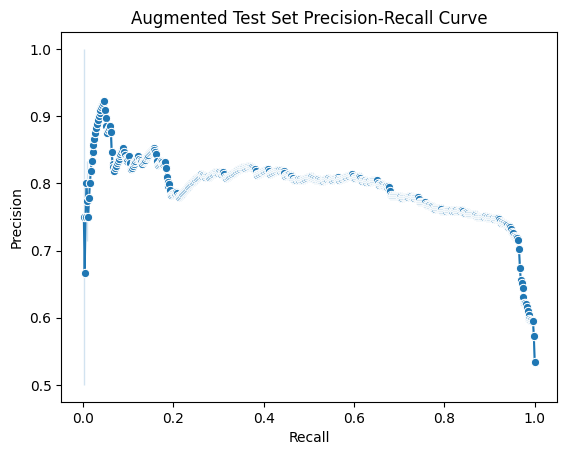

In [34]:
# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Gold Label Evaluation

In [35]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(classifier_match, axis=1)

In [36]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

Best Threshold: -0.03162895143032074
Best F1 Score: 0.7592592592592593
AUC-ROC: 0.6698841698841699


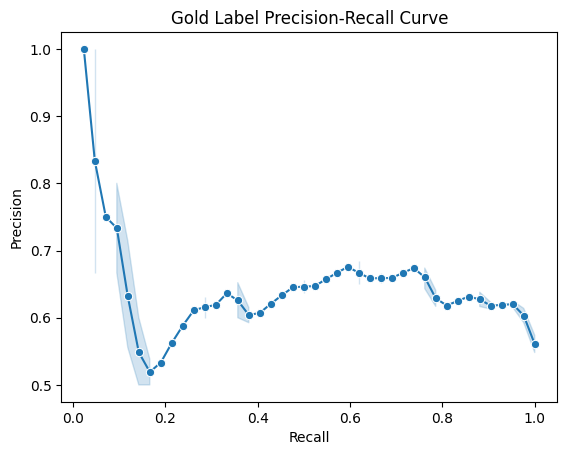

In [37]:
# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

In [38]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        # sbert_match_binary,
        classifier_match_boolean,
    ],
    threshold=best_threshold
)

In [39]:
grouped_df

,classifier_match_boolean_acc
Description,
Abbreviated street type for same address should match,1.0
Abbreviated vs. full street names for same address should match,1.0
Addition of parenthetical details for same address should match,1.0
Addresses that match are often missing countries,1.0
Adjacent or nearby building numbers means different address,1.0
...,...
Typographical errors in city of same address should match,1.0
Typographical errors in same address with country should match,1.0
Typographical errors in street name of same address should match,1.0


In [40]:
# Truthiness analysis
correct_df = raw_df[raw_df["classifier_match_boolean_correct"]].reset_index(drop=True)
print(f"Number correct: {len(correct_df):,}")

correct_df.head(20)

Number correct: 49


,Description,Address1,Address2,Label,classifier_match_boolean,classifier_match_boolean_correct
0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,1,True
1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,1,True
2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,1,True
3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,1,True
4,Numerical variations for same address should m...,"Third Ave, New York, NY","3rd Avenue, New York, New York",1,1,True
5,Different character sets for same address shou...,北京市朝阳区建国路88号,Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào,1,1,True
6,Variant formats of same address should match,上海市黄浦区南京东路318号,上海黄浦南京东路318号,1,1,True
7,Variant formats of same address should match,Shànghǎi Shì Huángpǔ Qū Nánjīng Dōng Lù 318 Hào,Shànghǎi Huángpǔ Nánjīng Dōng Lù 318 Hào,1,1,True
8,Formal and localized format of same address sh...,"B-14, Connaught Place, New Delhi, Delhi 110001...","B-14, CP, ND, DL 110001",1,1,True
9,Different character sets for same address shou...,"16, MG Road, Bangalore, Karnataka 560001, India","16, एमजी रोड, बैंगलोर, कर्नाटक 560001",1,1,True


In [41]:
# Error analysis
wrong_df = raw_df[raw_df["classifier_match_boolean_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df.head(20)

Number wrong: 30


,index,Description,Address1,Address2,Label,classifier_match_boolean,classifier_match_boolean_correct
0,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,0,False
1,6,Variant format of same address should match,"350 Fifth Avenue, New York, NY 10118","Empire State Bldg, 350 5th Ave, NY, NY 10118",1,0,False
2,7,Variant format of same address should match,"Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanb...","Ciragan Palace Hotel, Ciragan Street 32, Besik...",1,0,False
3,16,Different languages for same address should match,北京市东城区东长安街16号,"16 Dongchang'an St, Dongcheng, Beijing, China",1,0,False
4,19,Different levels of detail for the same addres...,"221B Baker Street, London, NW1 6XE, UK","221B Baker St, Marylebone, London NW1 6XE",1,0,False
5,21,Including and excluding building names for sam...,"The Empire State Building, 350 5th Ave, New Yo...","350 5th Ave, New York, NY 10118",1,0,False
6,25,Local vs. international formatting for same ad...,"221B Baker Street, London, NW1 6XE, UK","221B Baker Street, Marylebone, London, NW1 6XE...",1,0,False
7,30,"Including a business name or not, in same addr...","123 Main St, Springfield, IL","Company ABC, 123 Main St, Springfield, IL",1,0,False
8,35,Common typographical errors in same address sh...,"北京市东城区东长安街1号, 中国","北京市东城区东长安街1号, 中囯",1,0,False
9,42,Different street numbers means different address,"101 Oak Lane, Marietta, GA 30008","102 Oak Lane, Marietta, GA 30008",0,1,False


In [42]:
classifier_model.predict(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.9794847369194031

In [43]:
classifier_model.predict(
    "101 Oak Lane, Macon, GA 30308",
    "101 Oak Lane, Atlanta, GA 30408",
)

0.7906560301780701

In [44]:
classifier_model.predict(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9257922172546387

In [45]:
classifier_model.predict(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

-0.19255906343460083

In [46]:
classifier_model.predict(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.8544998168945312